In [1]:
import torch
import torchvision
from torch import nn
from transformers import AutoTokenizer, CLIPModel, CLIPVisionModelWithProjection
from train_c_controlnet import WurstCore
from train_b import WurstCore as WurstCoreB
from warp_core.utils import load_or_fail
import yaml
import matplotlib.pyplot as plt
from PIL import Image
import requests

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
# SETUP WARPCORE
# config_file = 'configs/controlnet_c_3b_base.yml'
# config_file = 'configs/controlnet_c_3b_canny.yml'
# config_file = 'configs/controlnet_c_3b_inpainting.yml'
# config_file = 'configs/controlnet_c_3b_qr.yml'
config_file = 'configs/controlnet_c_3b_sr.yml'
with open(config_file, "r", encoding="utf-8") as file:
    loaded_config = yaml.safe_load(file)
    loaded_config['use_fsdp'] = False
    loaded_config['batch_size'] = 4

warpcore = WurstCore(
    config_dict=loaded_config,
    device=device
)

# STAGE B
config_file_b = 'configs/finetune_b_3b.yml'
with open(config_file_b, "r", encoding="utf-8") as file:
    config_file_b = yaml.safe_load(file)
    config_file_b['use_fsdp'] = False
    config_file_b['batch_size'] = 4
    
warpcore_b = WurstCoreB(
    config_dict=config_file_b,
    device=device
)

>>> RESUMING TRAINING FROM ITER  1000


In [3]:
# SETUP MODELS & DATA
extras = warpcore.setup_extras_pre()
models = warpcore.setup_models(extras)
data = warpcore.setup_data(extras)
models.generator.bfloat16()
print("CONTROLNET READY")

extras_b = warpcore_b.setup_extras_pre()
models_b = warpcore_b.setup_models(extras_b)
models_b.generator.bfloat16()
print("STAGE B READY")
pass

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPVisionModelWithProjection: ['text_model.encoder.layers.3.self_attn.k_proj.weight', 'text_model.encoder.layers.3.self_attn.q_proj.bias', 'text_model.embeddings.token_embedding.weight', 'text_model.encoder.layers.9.self_attn.k_proj.weight', 'text_model.encoder.layers.7.layer_norm2.weight', 'text_model.encoder.layers.8.self_attn.out_proj.bias', 'text_model.encoder.layers.6.self_attn.k_proj.weight', 'text_model.encoder.layers.2.self_attn.v_proj.weight', 'text_model.encoder.layers.5.mlp.fc1.weight', 'text_model.encoder.layers.10.mlp.fc2.weight', 'text_model.encoder.layers.1.self_attn.k_proj.bias', 'text_model.encoder.layers.7.self_attn.out_proj.bias', 'text_model.encoder.layers.4.layer_norm1.weight', 'text_model.encoder.layers.0.mlp.fc1.weight', 'text_model.encoder.layers.10.self_attn.k_proj.weight', 'text_model.encoder.layers.2.self_attn.q_proj.bias', 'text_model.encoder.layers.5.layer

Training with batch size 4 (4/GPU)
CONTROLNET READY


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

STAGE B READY


In [5]:
# LOAD CHECKPOINT
# models.controlnet.load_state_dict(load_or_fail("/weka/home-warp/models/v3_release/stage_c_3b_controlnet_canny/controlnet_2k.safetensors"))
# models.controlnet.load_state_dict(load_or_fail("/weka/home-warp/models/v3_release/stage_c_3b_controlnet_canny/controlnet_10k.safetensors"))
# models.controlnet.load_state_dict(load_or_fail("/weka/home-warp/models/v3_release/stage_c_3b_controlnet_inpainting/controlnet.safetensors"))
models.controlnet.load_state_dict(load_or_fail("/weka/home-warp/models/v3_release/stage_c_3b_controlnet_sr/controlnet.safetensors"))


<All keys matched successfully>

torch.Size([4, 3, 1536, 1536])


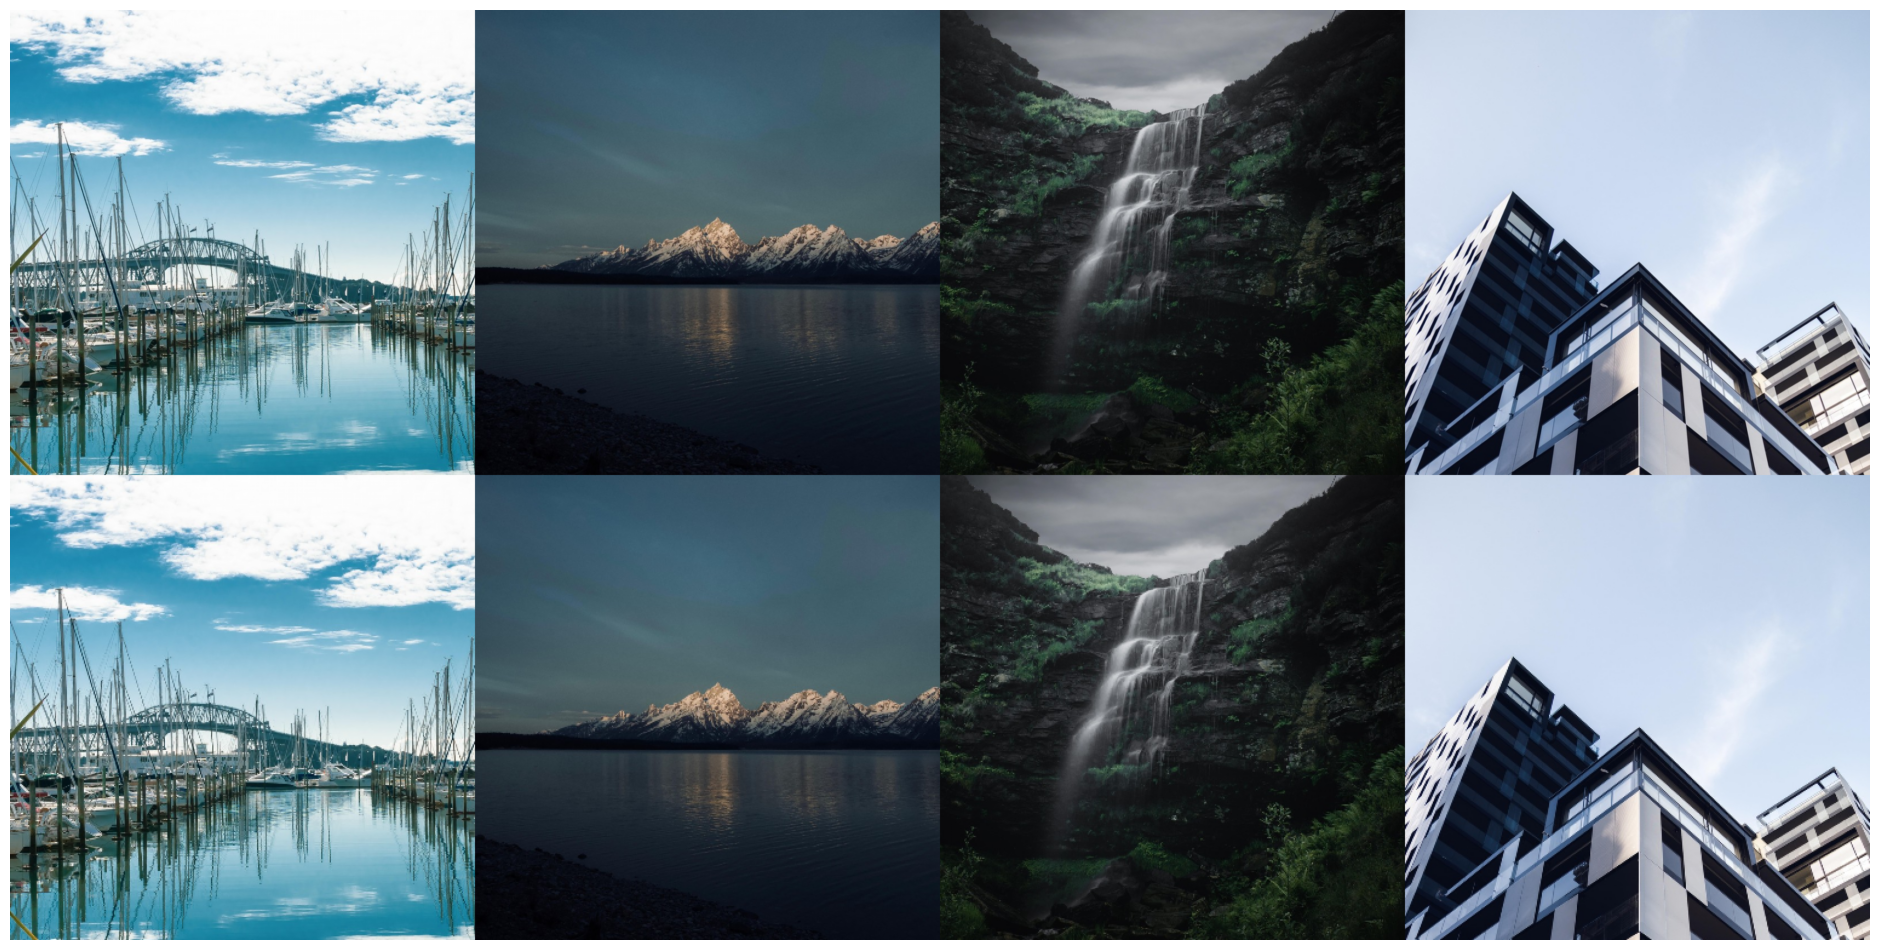

In [16]:
# PREVIEW BATCH
batch = next(data.iterator)
batch['images'] = nn.functional.interpolate(batch['images'], scale_factor=2, mode='nearest')

# Override Controlnet
cnet_override = None
# # url = "https://t3.ftcdn.net/jpg/02/96/04/04/360_F_296040417_6ANFXe238jcp5sGNPXfeF8sJ21VXJL9F.jpg" # CAT
# # url = "https://i.pinimg.com/474x/47/c1/a1/47c1a130bd0981d4543ce3083c855f84.jpg" # FACE
# url = "https://img.freepik.com/vector-gratis/fondo-espiral-blanco-negro_1048-16005.jpg?size=626&ext=jpg&ga=GA1.1.1880011253.1699574400&semt=ais" # SPIRAL
# # url = "https://cdn.discordapp.com/attachments/1039261364935462942/1197703805400260718/Captura_de_pantalla_2024-01-19_a_las_1.47.13.png?ex=65bc3b97&is=65a9c697&hm=ea02e4dbceb5d74a594ff40ea6d1d3da0a4d7a60de311c68210df8411f46b20c&" # SWAN
# # url = "https://media.es.wired.com/photos/655dabe4eb48c3d383bdfe1f/master/pass/Sam-Altman-OpenAI-Return-Business-1258197415.jpg" # SAM ALTMAN
# # url = "https://cdn.discordapp.com/attachments/1039261364935462942/1197882045435752538/Captura_de_pantalla_2024-01-19_a_las_13.35.31.png?ex=65bce197&is=65aa6c97&hm=2d754950b98615b6e18d37b0e51fef076f4958f01e3984846a877a188b3afe80&" # ICLR
# # url = "https://i2.wp.com/zet.gallery/blog/wp-content/uploads/2016/02/Vicent-Van-Gogh-Starry-Night-Famous-Oil-Paintings-www.shairart.com_.jpg?fit=1280%2C1014"
# images = extras.transforms(Image.open(requests.get(url, stream=True).raw).convert("RGB")).unsqueeze(0).to(device)
# images = images.expand(batch['images'].size(0), -1, -1, -1)
# # with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.bfloat16):
# #     cnet_override = models.controlnet(1-images.mean(dim=1, keepdim=True))
# batch['images'] = images.cpu()

with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.bfloat16):
    cnet, cnet_input = warpcore.get_cnet(batch, models, extras)
if cnet_override is None:
    with torch.no_grad():
        if cnet_input.size(1) == 1:
            cnet_input = cnet_input.repeat(1, 3, 1, 1)
        elif cnet_input.size(1) > 3:
            cnet_input_extra_channels = cnet_input[:, 3:]     
            cnet_input = cnet_input[:, :3]     
        print(cnet_input.shape)
else:
    cnet = cnet_override
    cnet_input = 1-images.mean(dim=1, keepdim=True).cpu().expand(-1, 3, -1, -1)

plt.figure(figsize=(24, 24))
plt.axis("off")
plt.imshow(torch.cat([
    torch.cat([i for i in batch['images'].clamp(0, 1)], dim=-1),
    torch.cat([i for i in cnet_input.clamp(0, 1).cpu()], dim=-1),
], dim=-2).permute(1, 2, 0).cpu())
plt.show()

In [17]:
# plt.figure(figsize=(24, 24))
# plt.axis("off")
# plt.imshow(torch.cat([
#     torch.cat([i for i in cnet_input_extra_channels.expand(-1, 3, -1, -1).clamp(0, 1)], dim=-1),
# ], dim=-2).permute(1, 2, 0).cpu())
# plt.show()

In [18]:
# batch['captions'] = ['colorful crayon drawing by a toddler, pastel colors'] * len(batch['captions'])
# batch['captions'] = ['Pixar style animation, still frame from Pixar movie Toy Story'] * len(batch['captions'])
# batch['captions'] = ['interesting image made with play-doh'] * len(batch['captions'])
# batch['captions'] = ['Oil painting'] * len(batch['captions'])
# batch['captions'] = ['oil painting of a swan by Botticelli'] * len(batch['captions'])
# batch['captions'] = ['oil painting of a dragon by Botticelli'] * len(batch['captions'])
# batch['captions'] = ['closeup photo of an android'] * len(batch['captions'])
# batch['captions'] = ['closeup photo of a greek marble sculpture wearing makeup'] * len(batch['captions'])
# batch['captions'] = ['closeup drawing of a Disney princess'] * len(batch['captions'])
# batch['captions'] = ['Play-doh figurine of a cute white cat surounded by other play-doh figures'] * len(batch['captions'])
# batch['captions'] = ['Photo of a man with facial hair'] * len(batch['captions'])
# batch['captions'] = ['Oil painting of a beautiful medieval town in France'] * len(batch['captions'])


In [19]:
# PREPARE CONDITIONS
conditions = warpcore.get_conditions(batch, models, extras, is_eval=True, is_unconditional=False, eval_image_embeds=False)
unconditions = warpcore.get_conditions(batch, models, extras, is_eval=True, is_unconditional=True, eval_image_embeds=False)    


In [20]:
cnet_multiplier = 1.0 # 0.8 # 0.3
conditions['cnet'] = [c.clone() * cnet_multiplier if c is not None else c for c in cnet]
unconditions['cnet'] = [c.clone() * cnet_multiplier if c is not None else c for c in cnet]
print("CNet Layers:", [i for i, p in enumerate(conditions['cnet']) if p is not None])


CNet Layers: [0, 4, 8, 12, 51, 55, 59, 63]


In [23]:
# SAMPLE
# extras.sampling_configs['cfg'] = 5
# extras.sampling_configs['shift'] = 1
# extras.sampling_configs['timesteps'] = 20
# extras.sampling_configs['t_start'] = 1.0
print(extras.sampling_configs)

with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.bfloat16), torch.random.fork_rng():
    torch.manual_seed(42)
    
    *_, (sampled_latents, _, _) = extras.gdf.sample(
        models.generator, conditions, (4, 16, 24, 24), # (4, 16, 24, 24),
        unconditions, device=device, **extras.sampling_configs
    )
    sampled = models.previewer(sampled_latents).float()
    print(sampled_latents.shape, sampled.shape)
    
    effnet_latents = warpcore.encode_latents(batch, models, extras)
    decoded = models.previewer(effnet_latents).float()

{'cfg': 5, 'sampler': <gdf.samplers.DDPMSampler object at 0x7f3369c80520>, 'shift': 1, 'timesteps': 20}
torch.Size([4, 16, 48, 48]) torch.Size([4, 3, 384, 384])


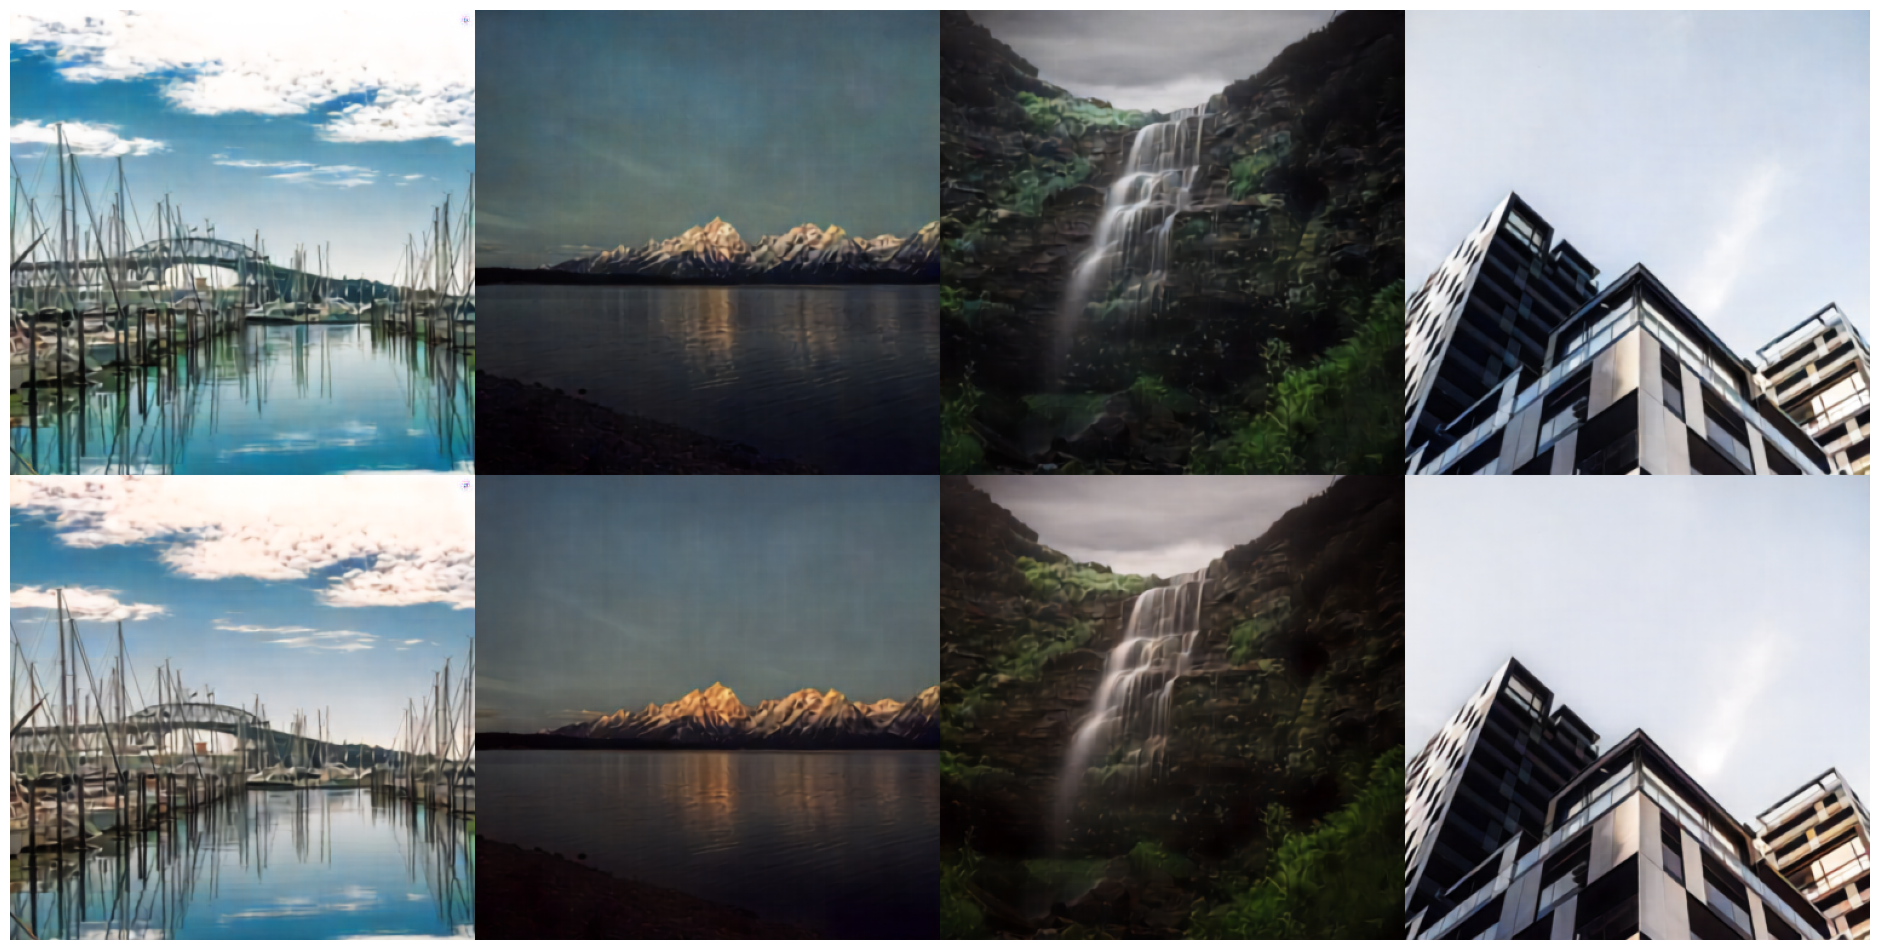

In [24]:
# VISUALIZE SAMPLES
# merged = decoded.clone()
# merged[:, :, :, 96:] = sampled[:, :, :, 96:]

plt.figure(figsize=(24, 24))
plt.axis("off")
plt.imshow(torch.cat([
    torch.cat([i for i in decoded.cpu().clamp(0, 1)], dim=-1),
    torch.cat([i for i in sampled.cpu().clamp(0, 1)], dim=-1),
#     torch.cat([i for i in merged.cpu().clamp(0, 1)], dim=-1),
], dim=-2).permute(1, 2, 0).cpu())
plt.show()

In [25]:
# STAGE B SAMPLING
conditions_b = warpcore_b.get_conditions(batch, models_b, extras_b, is_eval=True, is_unconditional=False, eval_image_embeds=False)
unconditions_b = warpcore_b.get_conditions(batch, models_b, extras_b, is_eval=True, is_unconditional=True, eval_image_embeds=False)
conditions_b['effnet'] = sampled_latents


In [ ]:
# SAMPLE
# extras_b.sampling_configs['cfg'] = 1.5
# extras_b.sampling_configs['shift'] = 1
# extras_b.sampling_configs['timesteps'] = 10
# extras_b.sampling_configs['t_start'] = 1.0
print(extras_b.sampling_configs)

with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.bfloat16), torch.random.fork_rng():
    torch.manual_seed(42)
    
    *_, (sampled_latents_b, _, _) = extras_b.gdf.sample(
        models_b.generator, conditions_b, (4, 4, 256, 256), # (4, 4, 256, 256),
        unconditions_b, device=device, **extras_b.sampling_configs
    )
    sampled_b = models_b.stage_a.decode(sampled_latents_b).float()
    print(sampled_latents.shape, sampled_b.shape)

{'cfg': 1.5, 'sampler': <gdf.samplers.DDPMSampler object at 0x7f326c25b9d0>, 'shift': 1, 'timesteps': 10}


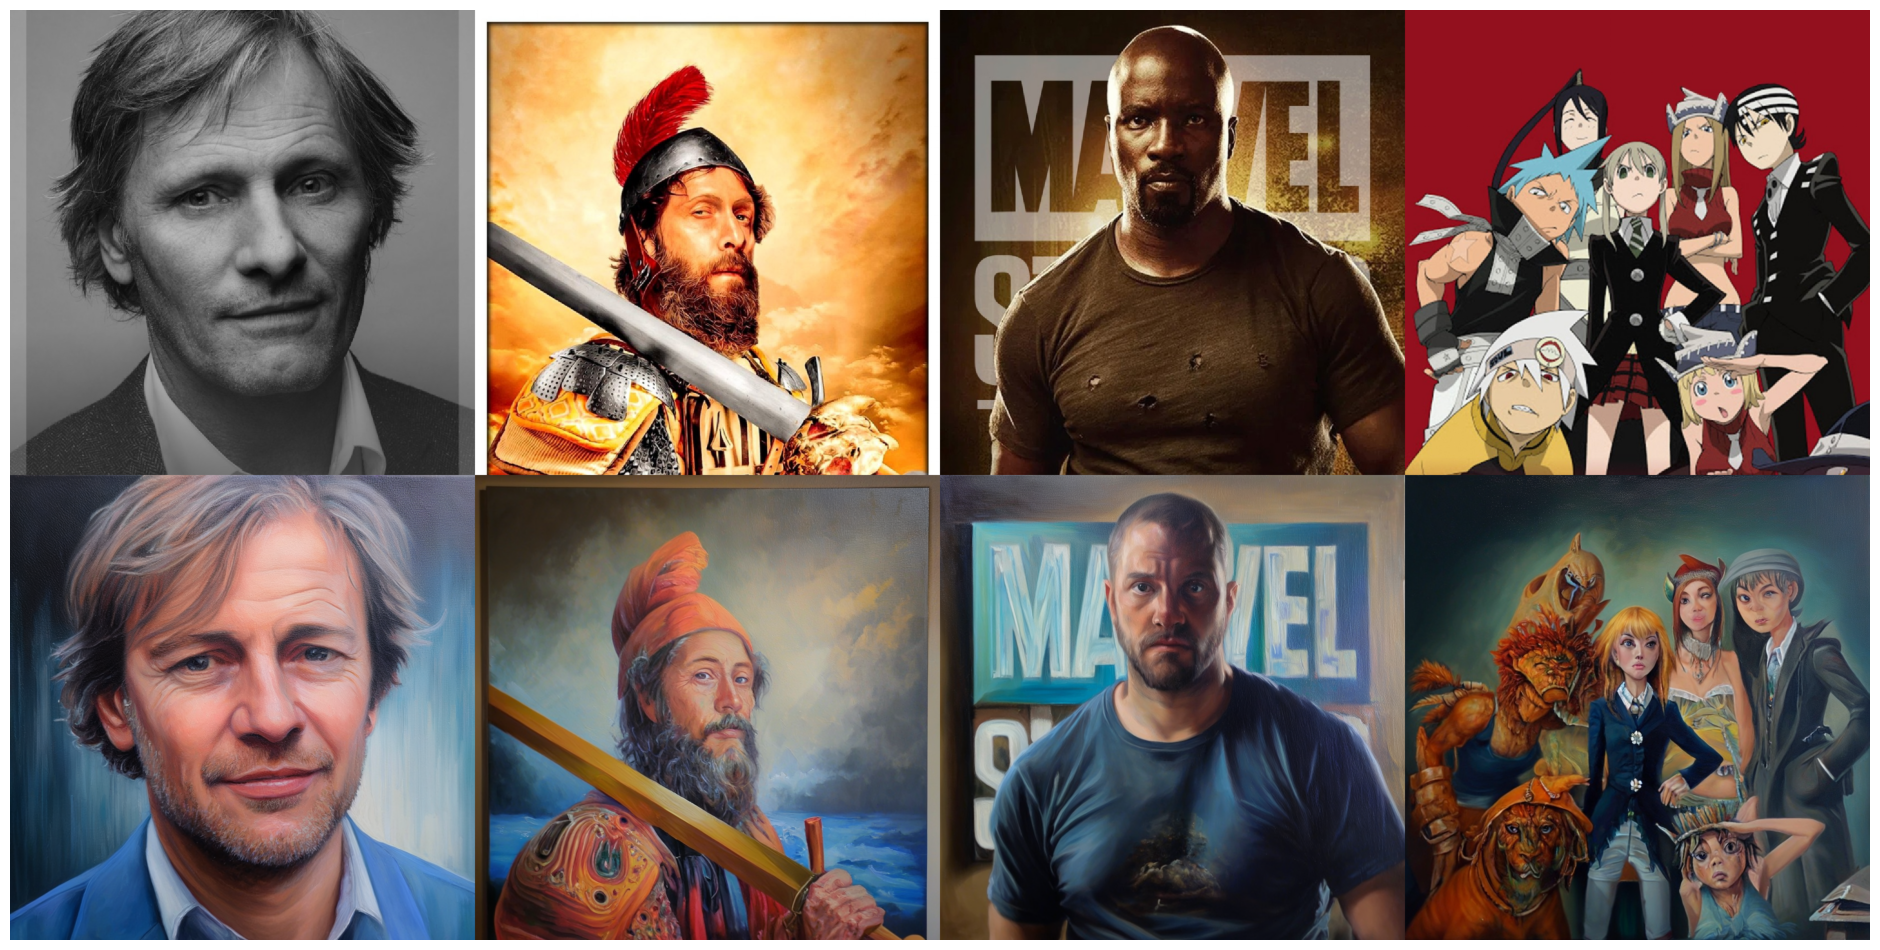

In [193]:
plt.figure(figsize=(24, 24))
plt.axis("off")
plt.imshow(torch.cat([
    torch.cat([i for i in nn.functional.interpolate(batch['images'], size=sampled_b.shape[-2:]).cpu().clamp(0, 1)], dim=-1),
    torch.cat([i for i in sampled_b.cpu().clamp(0, 1)], dim=-1),
], dim=-2).permute(1, 2, 0).cpu())
plt.show()

torchvision.utils.save_image(torch.cat([
    torch.cat([i for i in nn.functional.interpolate(batch['images'], size=sampled_b.shape[-2:]).cpu().clamp(0, 1)], dim=-1),
    torch.cat([i for i in sampled_b.cpu().clamp(0, 1)], dim=-1),
], dim=-2), f'controlnet_sample.jpg')